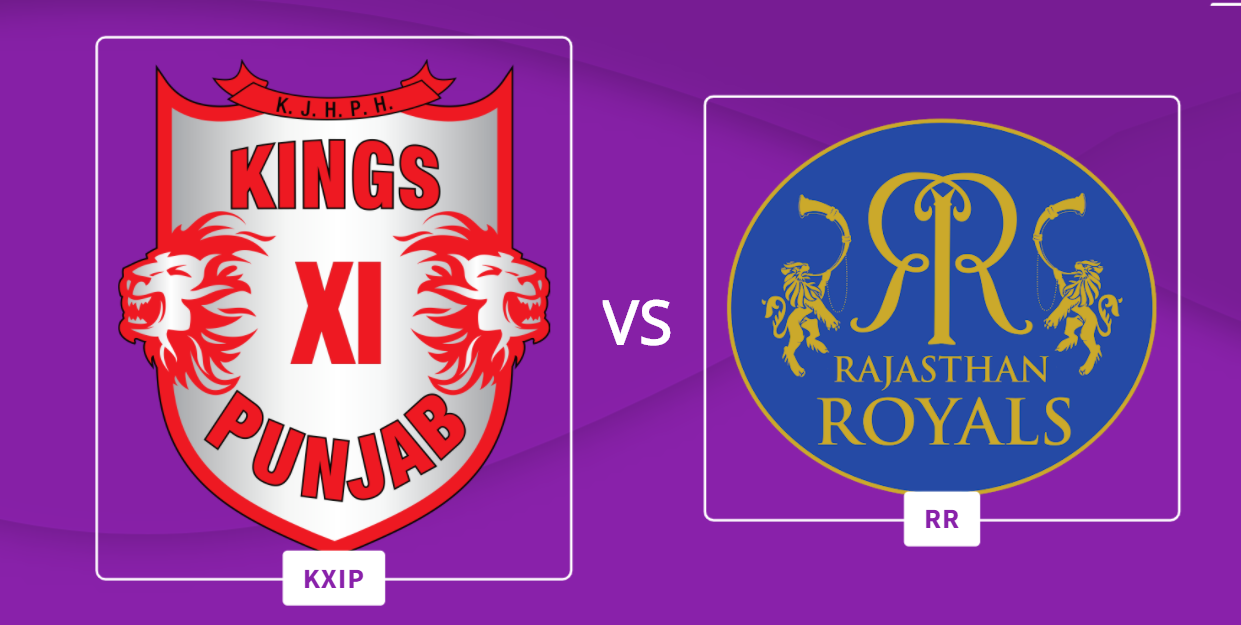

In [61]:
#!pip install bqplot
#!pip install ipywidgets
#!pip install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter nbextension install --user --py widgetsnbextension
#!jupyter nbextension enable --user --py widgetsnbextension
#!pip install plotly
#!pip install cufflinks


import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import bqplot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip
import cufflinks as cf
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
pd.set_option('display.max_columns', 50)
%matplotlib widget


In [62]:
matches = pd.read_csv("matches.csv")
deliveries =  pd.read_csv("deliveries.csv")
IPL_data = pd.merge(deliveries, matches[['id','season', 'team1', 'team2', 'toss_winner', 'toss_decision','winner','result', 'dl_applied','win_by_runs','win_by_wickets', 'venue' ]], 
                    left_on='match_id', right_on='id')

In [63]:
KXIP_bowlers = ['Mohammed Shami', 'A Singh', 'CJ Jordan' , 'M Ashwin', 'GJ Maxwell']
# R bishnoi: New (KXIP bowler) : ER: 7.85

KXIP_batsmen = ['KL Rahul', 'Mandeep Singh','CH Gayle', 'N Pooran', 'GJ Maxwell', 'DJ Hooda' ]
#'JDS Neesham', 'MA Agarwal'
# D padikkal new player(RCB batsmen): SR: 126.56, balls faced :192, Runs : 243, matches:7

#RR
RR_bowlers = ['J Archer' , 'AS Rajpoot', 'S Gopal' , 'R Tewatia', 'BA Stokes', 'S Tyagi']
RR_batsmen = ['RV Uthappa','BA Stokes', 'SV Samson', 'SPD Smith', 'JC Buttler', 'R Tewatia','R Parag','J Archer']


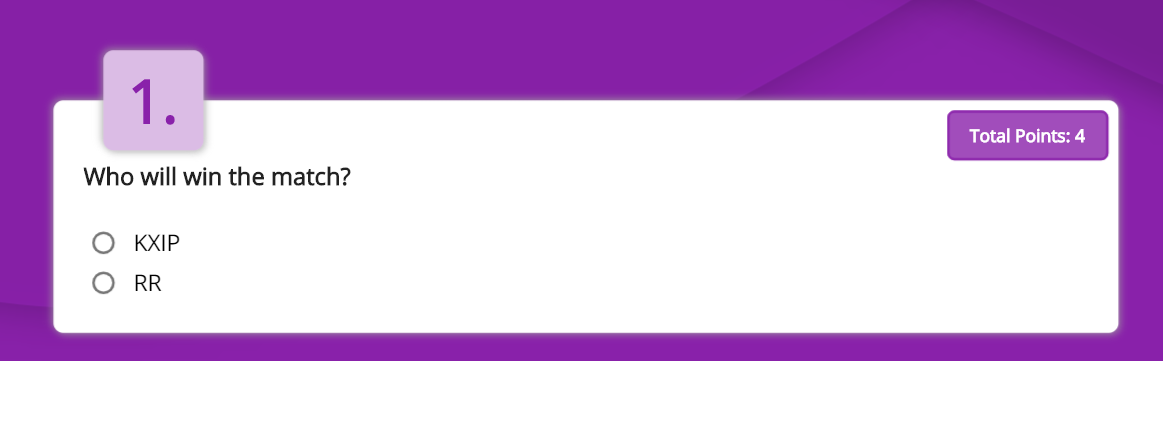

In [238]:

bowling_avg = deliveries[(deliveries.bowler.isin(KXIP_bowlers)) | (deliveries.bowler.isin(RR_bowlers))]
bowling_avg.player_dismissed.fillna(0, inplace  = True)
bowling_avg['player_dismissed'].loc[bowling_avg['player_dismissed'] != 0] = 1

b_avg1 = bowling_avg.groupby(['bowler'])['player_dismissed'].sum().reset_index(name  = "wickets")
t_b =  bowling_avg.groupby(['bowler'])['batsman_runs'].count().reset_index(name  = "balls_bowled")
b_avg1["balls_bowled"] = t_b.balls_bowled
b_avg1["bowling_avg"] = b_avg1.wickets/b_avg1.balls_bowled


display_side_by_side([b_avg1[b_avg1.bowler.isin(KXIP_bowlers)], b_avg1[b_avg1.bowler.isin(RR_bowlers)]], 
                     [" 1) bowling average of KXIP bowlers", " 2) bowling average of RR bowlers"])


## Batting averages of all the batsmen

batsmen_runs_all =deliveries[(deliveries.batsman.isin(KXIP_batsmen)) | (deliveries.batsman.isin(RR_batsmen))]
b1_all = batsmen_runs_all.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_runs")
b = [];b_avg = [];tm = [];runs  = []
for i in batsmen_runs_all.batsman.unique():
    x = batsmen_runs_all[batsmen_runs_all.batsman == i]
    x.player_dismissed.fillna(0, inplace = True)
    x['player_dismissed'].loc[x['player_dismissed'] != 0] = 1
    #print(x[['match_id','player_dismissed']])
    y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
    z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
    #print(y)
    b.append(i)
    b_avg.append(y.out_count.sum())
    runs.append(z.runs.sum())
    tm.append(y.shape[0])
    
bat_avg = pd.DataFrame(list(zip(b, b_avg, tm, runs)), 
               columns =['batsman','matches_out','total_matches', 'total_runs'])    

bat_avg["batting_average"] = bat_avg.total_runs/bat_avg.matches_out

display_side_by_side([bat_avg[bat_avg.batsman.isin(KXIP_batsmen)], bat_avg[bat_avg.batsman.isin(RR_batsmen)]],
                     [" 1) batting average of KXIP batsmen", " 2) batting average of RR batsmen"])

,bowler,wickets,balls_bowled,bowling_avg
0,A Singh,34,551,0.061706
3,CJ Jordan,14,213,0.065728
4,GJ Maxwell,17,432,0.039352
6,M Ashwin,15,432,0.034722
7,Mohammed Shami,52,1075,0.048372
,bowler,wickets,balls_bowled,bowling_avg
1,AS Rajpoot,22,452,0.048673
2,BA Stokes,29,615,0.047154
5,J Archer,27,514,0.052529
8,R Tewatia,16,301,0.053156


,batsman,matches_out,total_matches,total_runs,batting_average
0,DJ Hooda,33,45,535,16.212121
1,CH Gayle,110,124,4560,41.454545
2,Mandeep Singh,71,83,1547,21.788732
6,GJ Maxwell,62,67,1403,22.629032
10,KL Rahul,49,58,2013,41.081633
12,N Pooran,6,6,177,29.500000
,batsman,matches_out,total_matches,total_runs,batting_average
3,JC Buttler,38,45,1431,37.657895
4,SPD Smith,59,72,2047,34.694915
5,BA Stokes,30,32,647,21.566667


## Performance indexes of batsmen
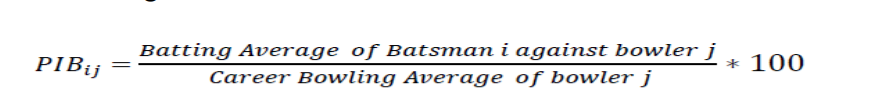


In [239]:
# Performance indexes of KXIP batsmen against RR bowlers
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
def performance_indexes_batsmen(batsman_list, bowler_list):
    
    for i in batsman_list:
        pi1 = deliveries[(deliveries.batsman == i) & (deliveries.bowler.isin(bowler_list))]
        pi1.player_dismissed.fillna(0, inplace = True)
        pi1['player_dismissed'].loc[pi1['player_dismissed'] != 0] = 1
        for j in pi1.bowler.unique():
            x = pi1[pi1.bowler == j]
            batsman.append(i)
            bowler.append(j)
            y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
            z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
            b_avg.append(y.out_count.sum())
            runs.append(z.runs.sum())
            tm.append(y.shape[0])
            
performance_indexes_batsmen(KXIP_batsmen, RR_bowlers)
KXIP_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
KXIP_bat_avg["batting_average"] = KXIP_bat_avg.total_runs/KXIP_bat_avg.matches_out
KXIP_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg = []
for i in KXIP_bat_avg.bowler.values:
    bowl_avg.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
KXIP_bat_avg["bowling_average_bowler"] = bowl_avg
KXIP_bat_avg["PIBij"] = KXIP_bat_avg.batting_average/KXIP_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %

#############################################################################################################33
# RR batsmen's performance indexes
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
performance_indexes_batsmen(RR_batsmen, KXIP_bowlers)

RR_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
RR_bat_avg["batting_average"] = RR_bat_avg.total_runs/RR_bat_avg.matches_out
RR_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg1 = []
for i in RR_bat_avg.bowler.values:
    bowl_avg1.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
RR_bat_avg["bowling_average_bowler"] = bowl_avg1
RR_bat_avg["PIBij"] = RR_bat_avg.batting_average/RR_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %
display_side_by_side([KXIP_bat_avg, RR_bat_avg],
                     [" 1) Performance indexes of KXIP batsmen against RR Bowlers", " 2) Performance indexes of RR batsmen against KXIP Bowlers"])

,batsman,bowler,matches_out,total_matches,total_runs,batting_average,bowling_average_bowler,PIBij
0,KL Rahul,J Archer,0,3,59,nan,0.052529,nan
1,KL Rahul,BA Stokes,0,2,21,nan,0.047154,nan
2,KL Rahul,S Gopal,0,2,19,nan,0.065767,nan
3,Mandeep Singh,AS Rajpoot,0,2,8,nan,0.048673,nan
4,Mandeep Singh,S Gopal,1,2,3,3.000000,0.065767,45.615385
5,Mandeep Singh,BA Stokes,0,2,6,nan,0.047154,nan
6,Mandeep Singh,J Archer,1,1,0,0.000000,0.052529,0.000000
7,CH Gayle,R Tewatia,0,1,1,nan,0.053156,nan
8,CH Gayle,AS Rajpoot,0,1,1,nan,0.048673,nan
9,CH Gayle,J Archer,2,4,23,11.500000,0.052529,218.925926


## Performance indexes for both the teams bowlers
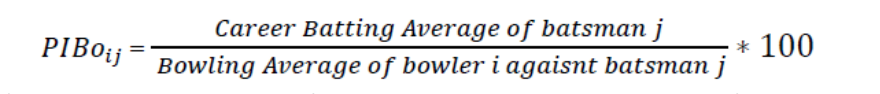

In [241]:
bowls = []; bats = []; wi = []; bb = []
def performance_index_bowlers(bowlers_list, batsmen_list):
    for i in bowlers_list:
        p = deliveries[(deliveries.bowler == i) & (deliveries.batsman.isin(batsmen_list))]
        p.player_dismissed.fillna(0, inplace  = True)
        p['player_dismissed'].loc[p['player_dismissed'] != 0] = 1
        for j in p.batsman.unique():
            bowls.append(i)
            bats.append(j)
            xy = p[p.batsman == j]
            #print(p[p.batsman == j])
            wi.append(xy.player_dismissed.sum())
            bb.append(xy.batsman_runs.count())
        
performance_index_bowlers(RR_bowlers, KXIP_batsmen)
RR_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in RR_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
RR_bowlers_p["bowling_average"] = RR_bowlers_p.wickets/RR_bowlers_p.balls_bowled
RR_bowlers_p["batting_avg"] = bat_avg_p
RR_bowlers_p["PIBoij"] = RR_bowlers_p.batting_avg/RR_bowlers_p.bowling_average
RR_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)
###################################################################################################################
bowls = []; bats = []; wi = []; bb = []        
performance_index_bowlers(KXIP_bowlers, RR_batsmen)

KXIP_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in KXIP_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
KXIP_bowlers_p["bowling_average"] = KXIP_bowlers_p.wickets/KXIP_bowlers_p.balls_bowled
KXIP_bowlers_p["batting_avg"] = bat_avg_p
KXIP_bowlers_p["PIBoij"] = KXIP_bowlers_p.batting_avg/KXIP_bowlers_p.bowling_average
KXIP_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)

display_side_by_side([RR_bowlers_p, KXIP_bowlers_p],
                     [" 1) Performance indexes of RR bowlers against KXIP batsmen", " 2) Performance indexes of KXIP bowlers against RR batsmen"])

,bowler,batsman,wickets,balls_bowled,bowling_average,batting_avg,PIBoij
0,J Archer,GJ Maxwell,1,3,0.333333,22.629032,67.887097
1,J Archer,KL Rahul,0,35,0.000000,41.081633,nan
2,J Archer,CH Gayle,2,19,0.105263,41.454545,393.818182
3,J Archer,N Pooran,1,7,0.142857,29.500000,206.500000
4,J Archer,Mandeep Singh,1,2,0.500000,21.788732,43.577465
5,AS Rajpoot,Mandeep Singh,0,11,0.000000,21.788732,nan
6,AS Rajpoot,GJ Maxwell,1,9,0.111111,22.629032,203.661290
7,AS Rajpoot,CH Gayle,0,4,0.000000,41.454545,nan
8,S Gopal,GJ Maxwell,1,1,1.000000,22.629032,22.629032
9,S Gopal,DJ Hooda,0,3,0.000000,16.212121,nan


## Conclusion : From the above analysis looks like: KXIP will be the winner

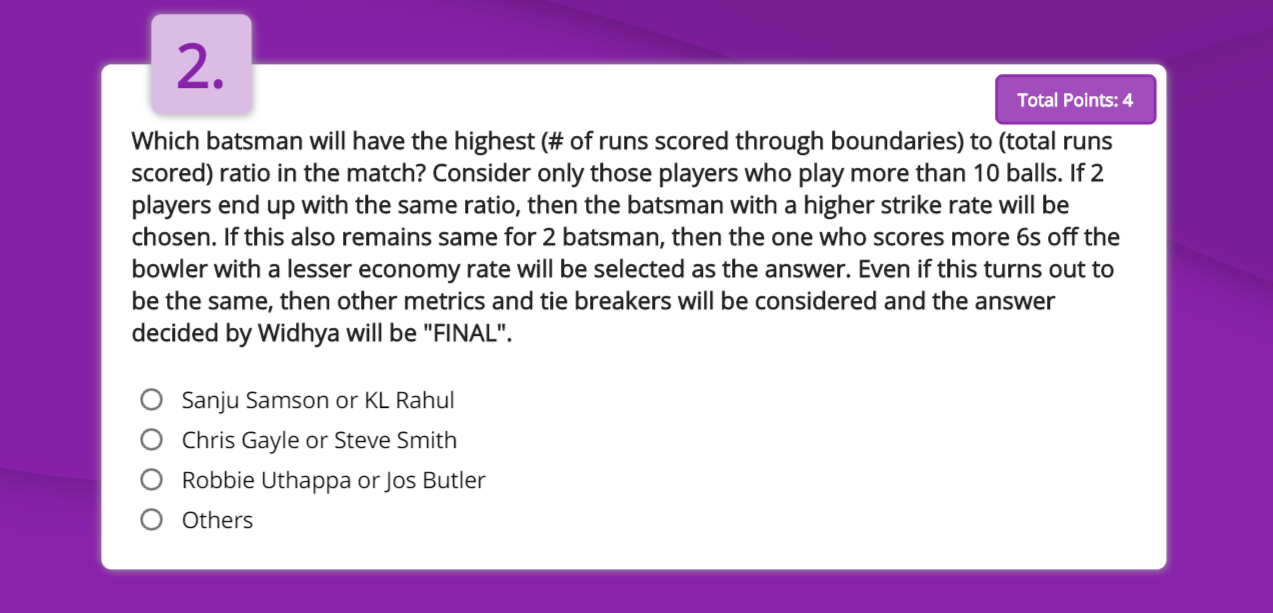

In [64]:
# Overall performnace in IPL
def runs_off_boundaries(total_score, batsmen_runs):
    off_boundaries = total_score.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_score")
    batsmen_boundaries = batsmen_runs.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "runs_offboundaries")
    batsmen_balls_faced = total_score.groupby(['batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    
    off_boundaries["runs_offboundaries"] = batsmen_boundaries.runs_offboundaries
    off_boundaries["BTR"] = off_boundaries.runs_offboundaries/off_boundaries.total_score
    off_boundaries["strike_rate"] = off_boundaries.total_score*100/batsmen_balls_faced.balls_faced
    off_boundaries.sort_values(by=['BTR'], inplace=True, ascending=False)
    return off_boundaries
###############################################################################################################################
# Matchwise average
def matchwise_runs_off_boundaries(m_total_score, m_batsmen_runs):
    matchwise_off_boundaries = m_total_score.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "total_score")
    matchwise_batsmen_boundaries = m_batsmen_runs.groupby(['match_id','batsman'])['batsman_runs'].sum().reset_index(name = "runs_offboundaries")
    matchwise_balls_faced = m_total_score.groupby(['match_id','batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    
    matchwise_off_boundaries["runs_offboundaries"] = matchwise_batsmen_boundaries.runs_offboundaries
    matchwise_off_boundaries["strike_rate"] = matchwise_off_boundaries.total_score*100/matchwise_balls_faced.balls_faced
    matchwise_off_boundaries.runs_offboundaries.fillna(0, inplace = True)
    bats = [];tscore = [];of_boundaries =[];strike_rate = []
    
    for i in matchwise_off_boundaries.batsman.unique():
        batsmen_boundaries_data = matchwise_off_boundaries[matchwise_off_boundaries.batsman == i]
        bats.append(i)
        tscore.append(batsmen_boundaries_data.total_score.mean())
        strike_rate.append(batsmen_boundaries_data.strike_rate.mean())
        of_boundaries.append(batsmen_boundaries_data.runs_offboundaries.mean())
        
    BTR =  pd.DataFrame(list(zip(bats, tscore, of_boundaries, strike_rate)), 
               columns =['batsman', 'total_score', 'runs_offboundaries', 'strike_rate'])
    BTR["BTR"] = BTR.runs_offboundaries/BTR.total_score
    BTR.sort_values(by = ['BTR'], inplace=True, ascending=False)
    return BTR

################################################################################################################################
# BTR =  Boundaries to Totatl Runs Ratio

In [65]:
KXIP_RR_batsmen  = deliveries[(deliveries.batsman.isin(KXIP_batsmen)) | (deliveries.batsman.isin(RR_batsmen))]
batsmen = KXIP_RR_batsmen[((KXIP_RR_batsmen.batsman_runs == 4) & (KXIP_RR_batsmen.extra_runs != 4)) | 
                          ((KXIP_RR_batsmen.batsman_runs == 6) & (KXIP_RR_batsmen.extra_runs != 6))]

# overall 
KXIP_RR_boundaries = runs_off_boundaries(KXIP_RR_batsmen, batsmen)

# matchwise
boundaries_runs_ratio = matchwise_runs_off_boundaries(KXIP_RR_batsmen, batsmen)

display_side_by_side([KXIP_RR_boundaries[KXIP_RR_boundaries.batsman.isin(KXIP_batsmen)], 
                      KXIP_RR_boundaries[KXIP_RR_boundaries.batsman.isin(RR_batsmen)],
                      boundaries_runs_ratio[boundaries_runs_ratio.batsman.isin(KXIP_batsmen)],
                      boundaries_runs_ratio[boundaries_runs_ratio.batsman.isin(RR_batsmen)]], 
                     ['Boundaries to Runs Ratio of KXIP Batsmen (Overall)',
                      'Boundaries to Runs Ratio of RR Batsmen (Overall)',
                      'Boundaries to Runs Ratio of KXIP batsmen(matchwise average)',
                     'Boundaries to Runs Ratio of RR batsmen(matchwise average)'])

################################################################################################################################
# Head to head 
KXIP_RR_faceoff = deliveries[((deliveries.bowler.isin(KXIP_bowlers)) & (deliveries.batsman.isin(RR_batsmen))) |
                       ((deliveries.bowler.isin(RR_bowlers)) & (deliveries.batsman.isin(KXIP_batsmen)))]
faceoff_batsmen = KXIP_RR_faceoff[((KXIP_RR_faceoff.batsman_runs == 4) & (KXIP_RR_faceoff.extra_runs != 4)) |
                      ((KXIP_RR_faceoff.batsman_runs == 6) & (KXIP_RR_faceoff.extra_runs != 6))]


# overall records head to head in IPL
KXIP_RR_boundaries_faceoff = runs_off_boundaries(KXIP_RR_faceoff, faceoff_batsmen)

# matchwise records head to head in IPL
boundaries_runs_ratio_faceoff = matchwise_runs_off_boundaries(KXIP_RR_faceoff, faceoff_batsmen)

display_side_by_side([KXIP_RR_boundaries_faceoff[KXIP_RR_boundaries_faceoff.batsman.isin(KXIP_batsmen)], 
                      KXIP_RR_boundaries_faceoff[KXIP_RR_boundaries_faceoff.batsman.isin(RR_batsmen)],
                      boundaries_runs_ratio_faceoff[boundaries_runs_ratio_faceoff.batsman.isin(KXIP_batsmen)],
                      boundaries_runs_ratio_faceoff[boundaries_runs_ratio_faceoff.batsman.isin(RR_batsmen)]], 
                     ['Boundaries to Runs Ratio of KXIP Batsmen against RR bowlers(Overall)',
                      'Boundaries to Runs Ratio of RR Batsmen against KXIP bowlers(Overall)',
                      'Boundaries to Runs Ratio of KXIP batsmen against RR bowlers(matchwise average)',
                     'Boundaries to Runs Ratio of RR batsmen against KXIP bowlers(matchwise average)'])


,batsman,total_score,runs_offboundaries,BTR,strike_rate
1,CH Gayle,4560,3450,0.756579,145.640370
3,GJ Maxwell,1403,986,0.702780,155.543237
8,N Pooran,177,124,0.700565,160.909091
6,KL Rahul,2013,1190,0.591157,137.406143
7,Mandeep Singh,1547,838,0.541694,123.365231
2,DJ Hooda,535,252,0.471028,124.129930
,batsman,total_score,runs_offboundaries,BTR,strike_rate
5,JC Buttler,1431,926,0.647100,150.000000
11,RV Uthappa,4446,2676,0.601889,127.319588
9,R Parag,169,98,0.579882,127.067669


,batsman,total_score,runs_offboundaries,BTR,strike_rate
8,N Pooran,9,22.000000,2.444444,69.230769
2,DJ Hooda,18,16.000000,0.888889,225.000000
3,GJ Maxwell,23,18.000000,0.782609,100.000000
6,KL Rahul,99,60.000000,0.606061,139.436620
1,CH Gayle,54,32.000000,0.592593,131.707317
7,Mandeep Singh,17,4.000000,0.235294,77.272727
,batsman,total_score,runs_offboundaries,BTR,strike_rate
4,J Archer,3,42.000000,14.000000,60.000000
0,BA Stokes,6,6.000000,1.000000,150.000000
5,JC Buttler,58,50.000000,0.862069,156.756757


# Answer : CH Gayle or SMD Smith

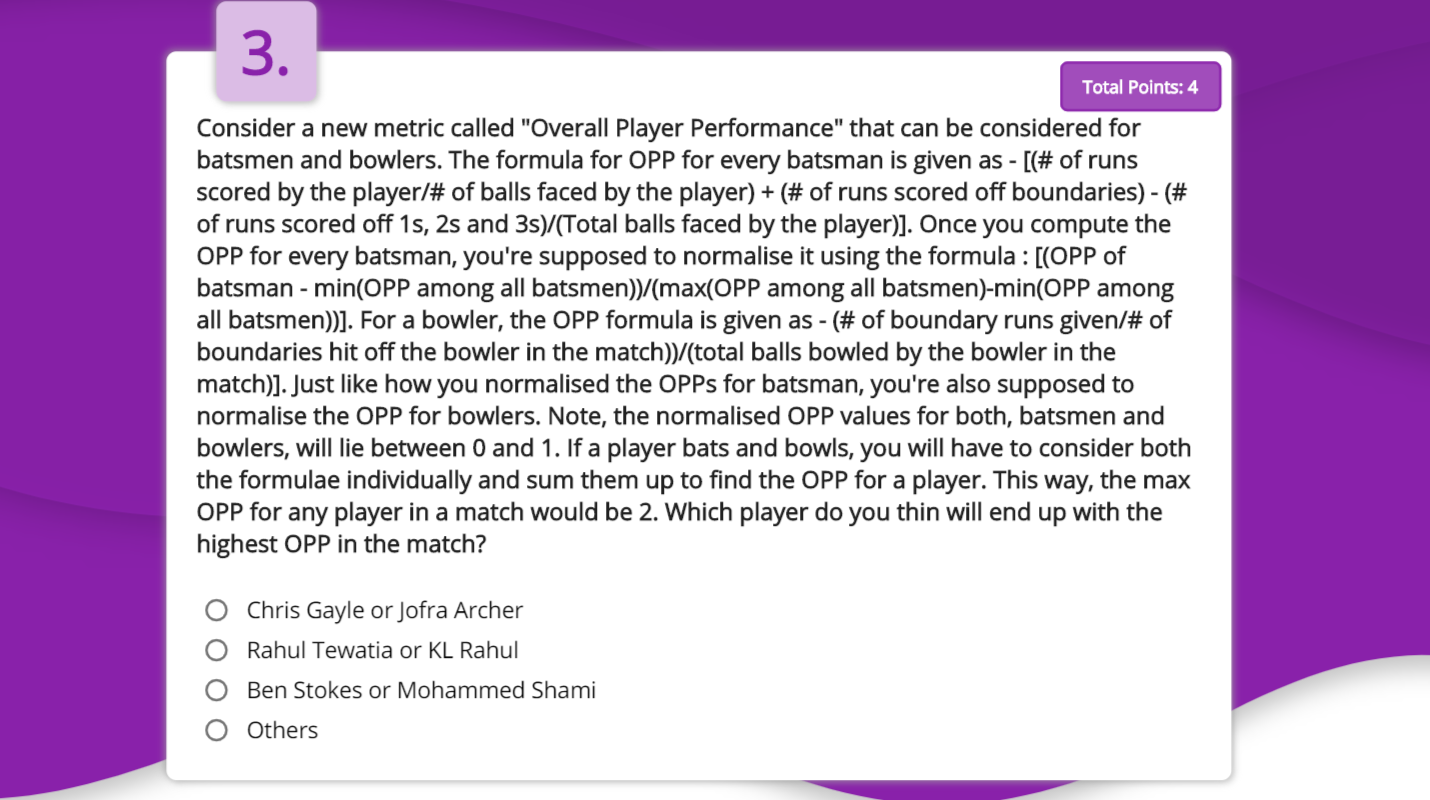

## OPP and Normalized of Batsmen


In [242]:
def OPP_batsmen(batsmen_data):
    # Total runs by the batsman
    total_runs = batsmen_data[batsmen_data.extra_runs == 0].groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_runs_scored")
    
    # Number of runs scored off the boundaries
    x = batsmen_data[((batsmen_data.batsman_runs == 4) & (batsmen_data.extra_runs != 4)) | 
                    ((batsmen_data.batsman_runs == 6) & (batsmen_data.extra_runs != 6))]
    
    runs_scoredoff_boundaries = x.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "runs_off_boundaries")
    
    # Number of runs scored by the batsman by 1s, 2s or 3s
    runs_123 = batsmen_data[((batsmen_data.batsman_runs ==3) & (batsmen_data.extra_runs != 3)) | 
                           ((batsmen_data.batsman_runs ==2) & (batsmen_data.extra_runs != 2)) | 
                           ((batsmen_data.batsman_runs ==1) & (batsmen_data.extra_runs != 1))]
    runs_1s_2s_3s = runs_123.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "runs_1s2s3s")
    
    # Number of balls_faced by batsman
    balls_faced = batsmen_data.groupby(['batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
    OPP = pd.DataFrame(list(zip(balls_faced.batsman,balls_faced.balls_faced, runs_1s_2s_3s.runs_1s2s3s, runs_scoredoff_boundaries.runs_off_boundaries, 
                           total_runs.total_runs_scored)), 
               columns =['batsman','balls_faced','1s2s3s', 'boundaries', 'total_runs'])
    
    OPP["OPP"] = ((OPP.total_runs/OPP.balls_faced)+ (OPP.boundaries) - (OPP["1s2s3s"])/(OPP.balls_faced))
    
    OPP.sort_values(by=['OPP'], inplace=True, ascending=False)
    return OPP
############################################################################################################################    
def normalize_OPP_batsman(OPP_overall):
    for i in OPP_overall.batsman.unique():
        batsman_.append(i)
        normalized = OPP_overall[OPP_overall.batsman == i]
        n_opp.append((normalized.OPP.values[0] - OPP_overall.OPP.min())/(OPP_overall.OPP.max() - OPP_overall.OPP.min()))
    n_OPP_batsmen  =  pd.DataFrame(list(zip(batsman_, n_opp)), 
               columns =['batsman', 'normalized_OPP'])
    
    n_OPP_batsmen.sort_values(by = ['normalized_OPP'], inplace=True, ascending=False)
    return n_OPP_batsmen
#############################################################################################################################    
OPP_overall = OPP_batsmen(KXIP_RR_batsmen)
batsman_ =[];n_opp=[]
normalize_OPP_batsmen = normalize_OPP_batsman(OPP_overall)

display_side_by_side([OPP_overall[OPP_overall.batsman.isin(KXIP_batsmen)], 
                      OPP_overall[OPP_overall.batsman.isin(RR_batsmen)], 
                      normalize_OPP_batsmen[normalize_OPP_batsmen.batsman.isin(KXIP_batsmen)],
                      normalize_OPP_batsmen[normalize_OPP_batsmen.batsman.isin(RR_batsmen)]], 
                     ['OPP for KXIP Batsmen', 'OPP for RR Batsmen',
                     'OPP for KXIP Batsmen(normalized)', 'OPP for RR Batsmen(normalized)'])

fig = px.bar(normalize_OPP_batamen, x="batsman", y='normalized_OPP',
             hover_data=['batsman', 'normalized_OPP'],color = 'batsman',
             title=' Figure 1 : OPP of KXIP and RR batsmen')
#fig.show()

,batsman,balls_faced,1s2s3s,boundaries,total_runs,OPP
1,CH Gayle,3131,1057,3450,4469,3451.089748
6,KL Rahul,1465,787,1190,1975,1190.810922
3,GJ Maxwell,902,412,986,1394,987.088692
7,Mandeep Singh,1254,687,838,1530,838.672249
2,DJ Hooda,431,273,252,519,252.570766
8,N Pooran,110,44,124,168,125.127273
,batsman,balls_faced,1s2s3s,boundaries,total_runs,OPP
11,RV Uthappa,3492,1718,2676,4403,2676.768900
13,SV Samson,1728,996,1214,2208,1214.701389
12,SPD Smith,1616,1013,1018,2006,1018.614480


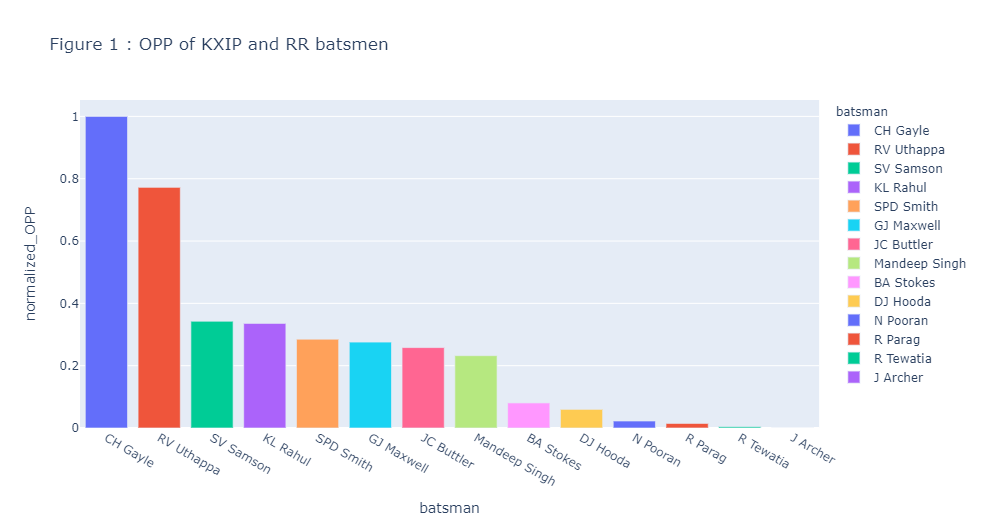

## OPP and normalized of Bowlers

In [244]:
bowlers_KXIP_RR = deliveries[(deliveries.bowler.isin(KXIP_bowlers)) | (deliveries.bowler.isin(RR_bowlers))]

def OPP_bowlers(bowler_data):
    # Boundary runs given
    b_runs = bowler_data[((bowler_data.batsman_runs == 4) & (bowler_data.extra_runs != 4)) | 
                         ((bowler_data.batsman_runs == 6) & (bowler_data.extra_runs != 6))]
    
    boundary_runs = b_runs.groupby(['bowler'])['batsman_runs'].sum().reset_index(name = "boundary_runs")
    
    # No. of boundary runs given
    no_boundary_runs = b_runs.groupby(['bowler'])['batsman_runs'].count().reset_index(name = "no_boundaries")
    
    # Total balls bowled 
    OPP_bowler = b_runs.groupby(['bowler'])['batsman_runs'].count().reset_index(name = "balls_bowled")
    
    OPP_bowler["no_boundaries"] = no_boundary_runs.no_boundaries
    OPP_bowler["boundary_runs"] = boundary_runs.boundary_runs
    
    OPP_bowler["OPP"] = (OPP_bowler.boundary_runs/OPP_bowler.no_boundaries)/(OPP_bowler.balls_bowled)
    OPP_bowler.sort_values(by=['OPP'], inplace=True, ascending=False)
    
    return OPP_bowler



def normalize_OPP_bowler(OPP_overall):
    for i in OPP_overall.bowler.unique():
        bowler_.append(i)
        normalized_b = OPP_overall[OPP_overall.bowler == i]
        n_opp_bowler.append((normalized_b.OPP.values[0] - OPP_overall.OPP.min())/(OPP_overall.OPP.max() - OPP_overall.OPP.min()))
    
    n_OPP_bowlers  =  pd.DataFrame(list(zip(bowler_, n_opp_bowler)), 
               columns =['bowler', 'normalized_OPP'])
    
    n_OPP_bowlers.sort_values(by = ['normalized_OPP'], inplace=True, ascending=False)
    return n_OPP_bowlers


OPP_bowler_ = OPP_bowlers(bowlers_KXIP_RR)
bowler_=[];n_opp_bowler=[]
normalize_OPP_bowlers = normalize_OPP_bowler(OPP_bowler_)


display_side_by_side([OPP_bowler_[OPP_bowler_.bowler.isin(KXIP_bowlers)], 
                      OPP_bowler_[OPP_bowler_.bowler.isin(RR_bowlers)], 
                      normalize_OPP_bowlers[normalize_OPP_bowlers.bowler.isin(KXIP_bowlers)],
                      normalize_OPP_bowlers[normalize_OPP_bowlers.bowler.isin(RR_bowlers)]], 
                     ['OPP for KXIP Bowlers', 'OPP for RR Bowlers',
                     'OPP for KXIP Bowlers(normalized)', 'OPP for RR Bowlers(normalized)'])

fig = px.bar(normalize_OPP_bowlers, x="bowler", y='normalized_OPP',
             hover_data=['bowler', 'normalized_OPP'],color = 'bowler',
             title=' Figure 2 : OPP of KXIP and RR bowlers')
#fig.show()

,bowler,balls_bowled,no_boundaries,boundary_runs,OPP
3,CJ Jordan,36,36,168,0.129630
6,M Ashwin,60,60,280,0.077778
4,GJ Maxwell,71,71,348,0.069034
0,A Singh,100,100,442,0.044200
7,Mohammed Shami,217,217,986,0.020939
,bowler,balls_bowled,no_boundaries,boundary_runs,OPP
8,R Tewatia,37,37,188,0.137327
10,S Tyagi,46,46,208,0.098299
9,S Gopal,77,77,386,0.065104
5,J Archer,80,80,372,0.058125


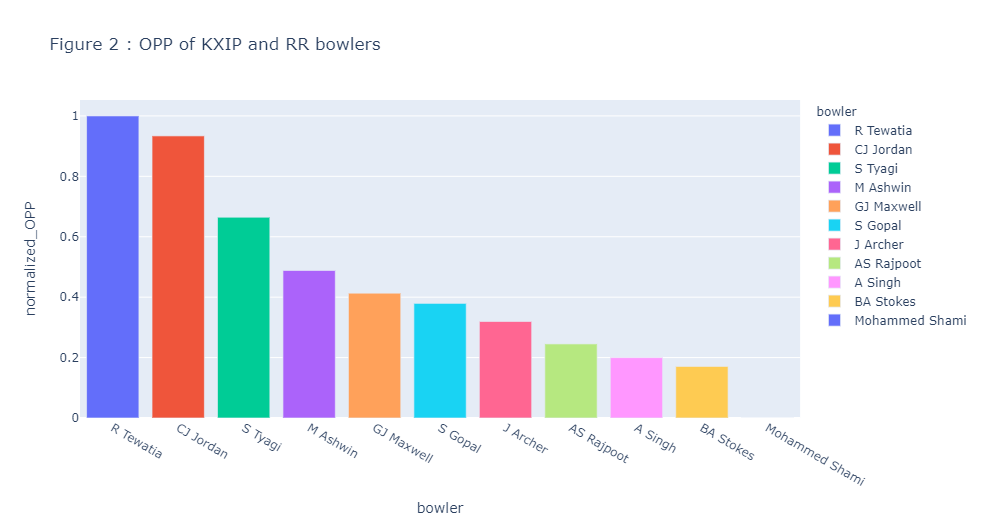

## Combined OPP(Final)

In [246]:
normalize_OPP_bowlers.rename(columns = {'bowler':'player'}, inplace = True)
normalize_OPP_batsmen.rename(columns = {'batsman':'player'}, inplace = True)
OPP_combined = normalize_OPP_batsmen.append(normalize_OPP_bowlers,ignore_index = True)

OPP_final_KXIP_RR = OPP_combined.groupby(['player'])['normalized_OPP'].sum().reset_index()
OPP_final_KXIP_RR.sort_values(by = ['normalized_OPP'], inplace=True, ascending=False)
display_side_by_side([normalize_OPP_batsmen, normalize_OPP_bowlers, OPP_final_KXIP_RR],
                     [" OPP of batsmen", "OPP of bowlers", "Final opp for KXIP and RR players"])

fig = px.bar(OPP_final_KXIP_RR, x="player", y='normalized_OPP',
             hover_data=['player', 'normalized_OPP'],color = 'player',
             title=' Figure 3 : OPP of KXIP and RR players')
#fig.show()


,player,normalized_OPP
0,CH Gayle,1.000000
1,RV Uthappa,0.772416
2,SV Samson,0.342693
3,KL Rahul,0.335671
4,SPD Smith,0.285060
5,GJ Maxwell,0.275794
6,JC Buttler,0.258125
7,Mandeep Singh,0.232172
8,BA Stokes,0.080505
9,DJ Hooda,0.059908


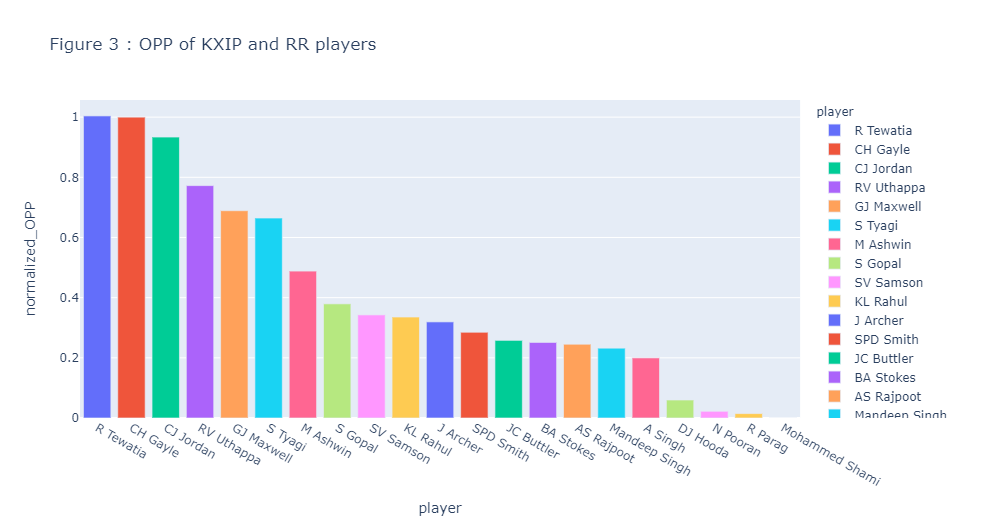

In [247]:
print("OPP_option1 R Tewatia and KL Rahul:", OPP_final_KXIP_RR[OPP_final_KXIP_RR.player == 'R Tewatia'].normalized_OPP.values[0], 
",", OPP_final_KXIP_RR[OPP_final_KXIP_RR.player == 'KL Rahul'].normalized_OPP.values[0])


print("OPP_option2 CH Gayle and J Archer:", OPP_final_KXIP_RR[OPP_final_KXIP_RR.player == 'CH Gayle'].normalized_OPP.values[0], 
",", OPP_final_KXIP_RR[OPP_final_KXIP_RR.player == 'J Archer'].normalized_OPP.values[0])



OPP_option1 R Tewatia and KL Rahul: 1.0040926830387131 , 0.3356708511465107
OPP_option2 CH Gayle and J Archer: 1.0 , 0.319501195821268


### Batting orders and bowling types need to be considered here.

## Answer = Tewatia and KL Rahul

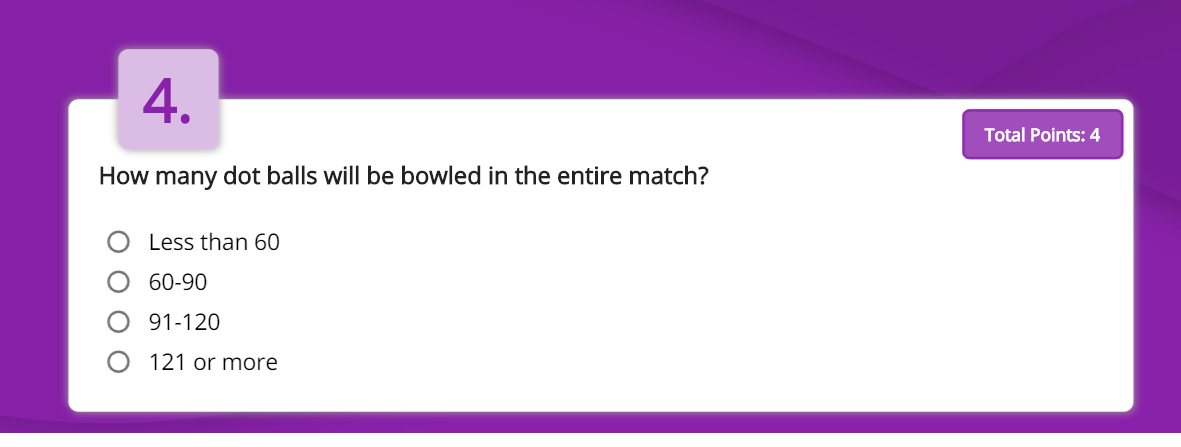

In [248]:
dot = deliveries[(deliveries.bowler.isin(KXIP_bowlers)) | (deliveries.bowler.isin(RR_bowlers))]
dot_balls = dot[(dot.batsman_runs == 0) & (dot.extra_runs == 0)].groupby(['match_id', 'bowler'])['batsman_runs'].count().reset_index(name  = "dot_balls")
bowler_dot=[];dotb=[]
for i in dot_balls.bowler.unique():
    bowler_dot.append(i)
    dotb.append(dot_balls[dot_balls.bowler == i].dot_balls.mean())

total_dotballs = pd.DataFrame((list(zip(bowler_dot, dotb))), columns =["bowler", "dot_balls"])
fig = px.bar(total_dotballs, x="bowler", y='dot_balls',
             hover_data=['bowler', 'dot_balls'],color = 'bowler',
             title=' Figure 4 : Dot balls bowled by KXIP and RR bowlers')
#fig.show()  

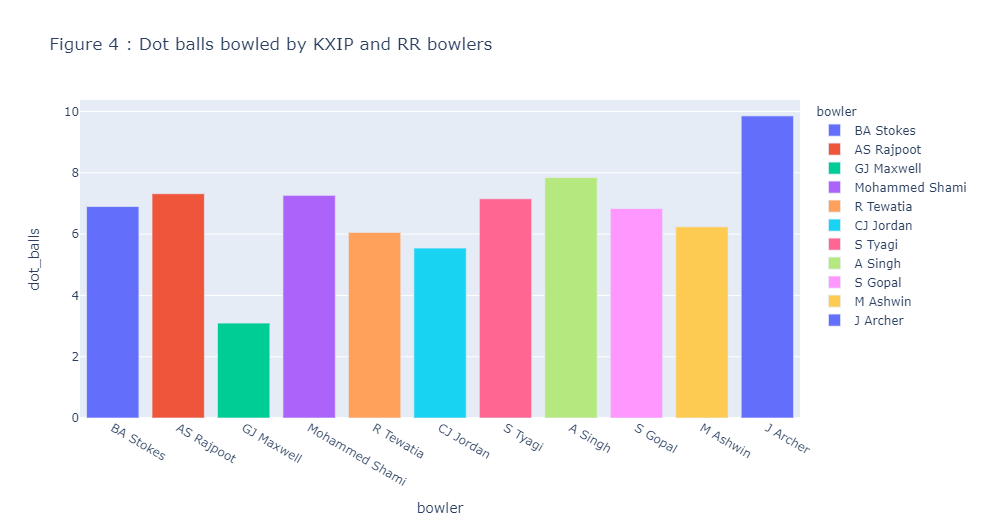

In [249]:
print("total dot balls bowled will be : ",total_dotballs.dot_balls.sum())

total dot balls bowled will be :  74.11063044582208


## Conclusion : Dot ball will be 60-90

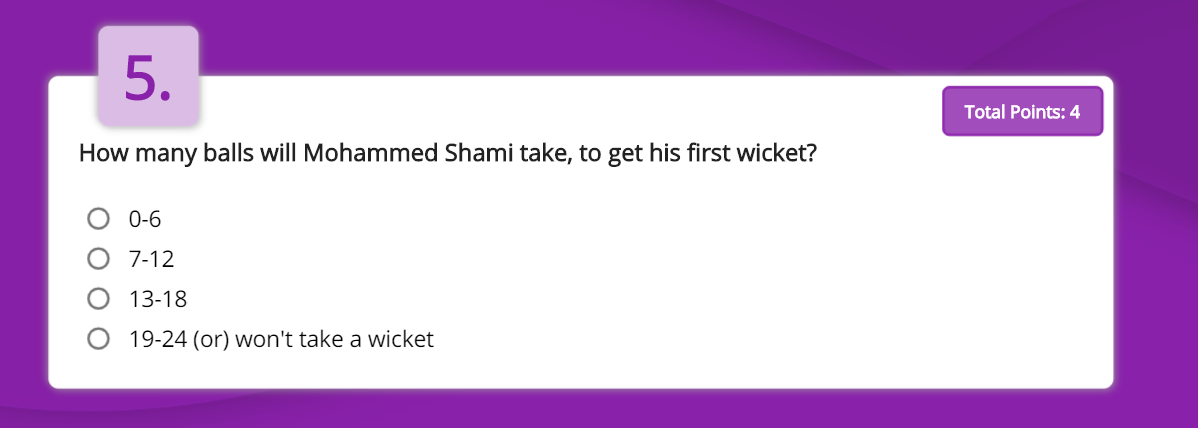

## 5.1 : Balls taken by Mohammed Shami to take 1st wicket in IPL (Overall)

In [251]:
M_Shami = deliveries[deliveries.bowler == 'Mohammed Shami']
M_Shami.player_dismissed.fillna(0, inplace = True)
M_Shami['player_dismissed'].loc[M_Shami['player_dismissed'] != 0] = 1

def M_Shami_wickets_data(data_):
    for i in data_.match_id.unique():
        match_num.append(i)
        match_data = data_[data_.match_id == i].reset_index()
        first_wicket = (match_data.player_dismissed.values != 0).argmax()
        wicket_details = match_data[:first_wicket]
        if wicket_details.batsman_runs.count() ==0:
            status.append("no_wicket")
        else:
            status.append("wicket")
        no_of_balls.append(wicket_details.batsman_runs.count())
    first_wicket_details = pd.DataFrame(list(zip(match_num, no_of_balls, status )), 
               columns =["match_id", "no_of_balls", "wicket_status"])

    return first_wicket_details

match_num = []; no_of_balls = [];status=[]
first_wicket_details_ = M_Shami_wickets_data(M_Shami)

pie_data1 = [(first_wicket_details_[first_wicket_details_.no_of_balls == 0].shape[0]/first_wicket_details_.shape[0])*100,
            (first_wicket_details_[first_wicket_details_.no_of_balls != 0].shape[0]/first_wicket_details_.shape[0])*100]
pie_labels1 = ["No wickets", "Wickets"]

# plot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip

def pie_plot(pie_data,pie_labels, title):
    pie = Pie(sizes=list(pie_data), labels=list(pie_labels),
              stroke="black",
              opacities = [0.8, 0.8],
              radius=80, inner_radius=0,
              sort=True,
              display_values=True, values_format='0.0f',
              label_color="white", font_size="10px", font_weight="bolder"
              )
    fig = Figure(marks=[pie],
             legend_location = "top",
             title=title,
             fig_margin= dict(top=60, bottom=40, left=50, right=20),
             background_style = {"fill":"black"}
                )
    fig.layout.width="400px"
    fig.layout.height="400px"
    pie.tooltip = Tooltip(fields=['sizes'], labels=["Count"], formats=["0.1f"])
    return fig
    
fig1  =pie_plot(pie_data1 ,pie_labels1, "Mohammed Shami's wickets percentage")
#fig1

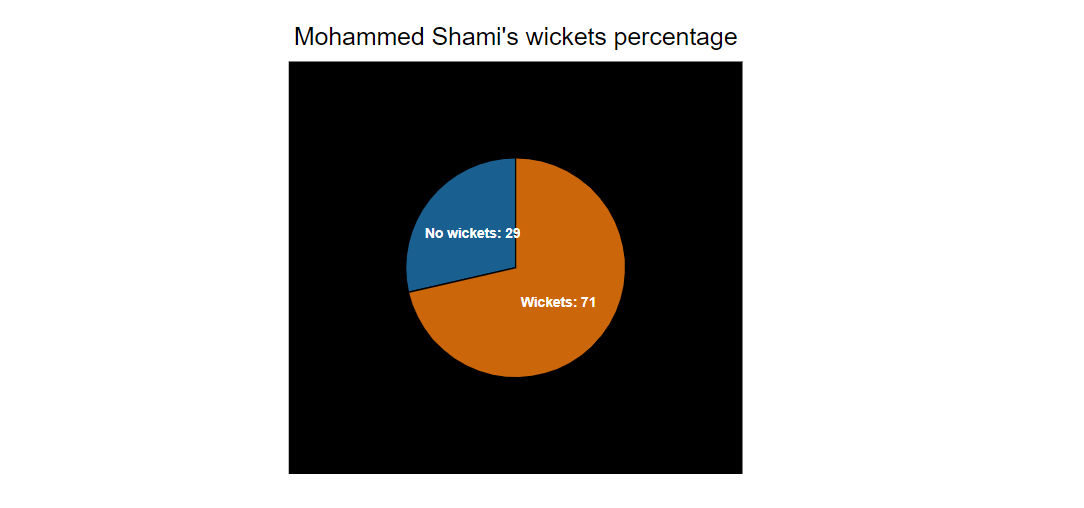

In [ ]:
means = first_wicket_details_[first_wicket_details_.no_of_balls !=0]
means.iplot(kind="hist",
              bins=50, colors=["red"],
              keys=["no_of_balls"],
              dimensions=(600, 400),
              title="Number of balls taken bu Mohammad shami to take his 1st wicket")

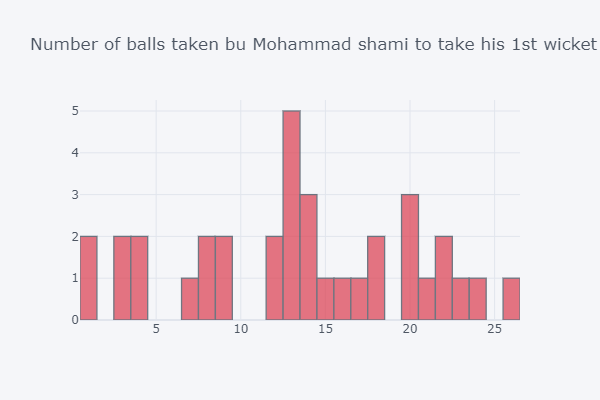

## 5.2 Mohammed Shami's 1st wicket against RR batsmen

In [233]:
#RR_batsmen_pp = ['RV Uthappa', 'BA Stokes', 'SPD Smith', 'SV Samson']
m_shami = deliveries[deliveries.bowler == "Mohammed Shami"]
m_shami_rr_batsmen.player_dismissed.fillna(0, inplace = True)

balls=[];matchid=[]; status =[]
for i in m_shami_rr_batsmen.match_id.unique():
    matchid.append(i)
    m_shami_match = m_shami[m_shami.match_id == i]
    ball_count = (m_shami_match.player_dismissed.isin(RR_batsmen) == True).argmax()
    if ball_count:
        balls.append(ball_count)
        status.append("wicket")
        
    else:
        balls.append(0)
        status.append("No_wicket")

   
first_wicket_details_against_RR_batsmen = pd.DataFrame(list(zip(matchid, balls, status)), 
               columns =["match_id", "no_of_balls", "wicket_status"])
first_wicket_details_against_RR_batsmen

,match_id,no_of_balls,wicket_status
0,51,17,wicket
1,463,0,No_wicket
2,480,0,No_wicket
3,485,0,No_wicket
4,602,0,No_wicket
5,7899,21,wicket
6,11140,22,wicket
7,11142,0,No_wicket
8,11323,12,wicket


In [252]:
pie_data4 = [(first_wicket_details_against_RR_batsmen[first_wicket_details_against_RR_batsmen.no_of_balls == 0].shape[0]/first_wicket_details_against_RR_batsmen.shape[0])*100,
            (first_wicket_details_against_RR_batsmen[first_wicket_details_against_RR_batsmen.no_of_balls != 0].shape[0]/first_wicket_details_against_RR_batsmen.shape[0])*100]
pie_labels4 = ["No wickets", "Wickets"]

fig4  =pie_plot(pie_data4 ,pie_labels4, "Shami's wicket % against RR batsmen")
#fig4

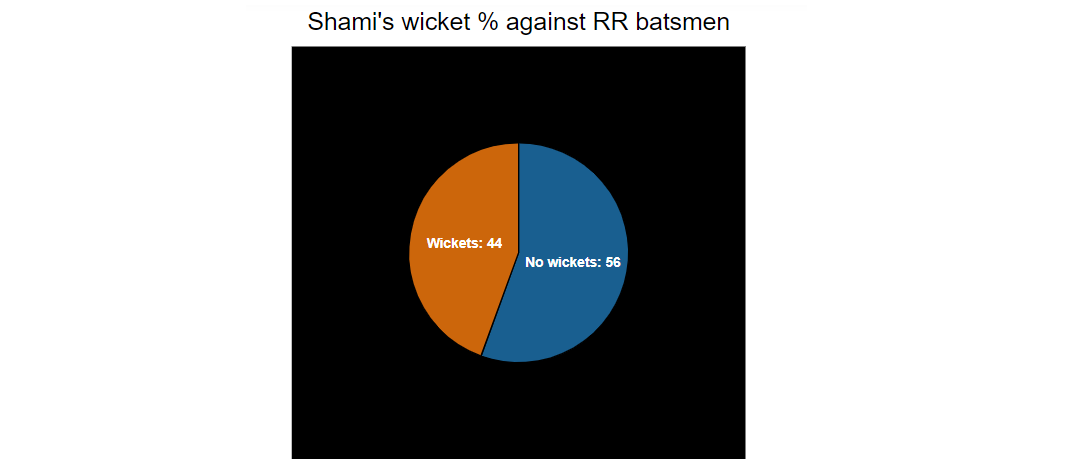

In [ ]:
balls_plot = first_wicket_details_against_RR_batsmen[first_wicket_details_against_RR_batsmen.no_of_balls !=0]
balls_plot.iplot(kind="hist",
              bins=50, colors=["red"],
              keys=["no_of_balls"],
              dimensions=(800, 400),
              title="Number of balls taken by Mohammad shami to take his 1st wicket against RR batsmen")

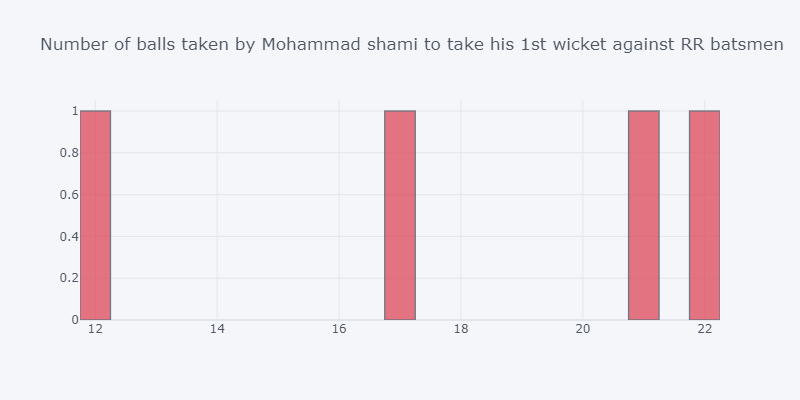

In [236]:
print("Average number of balls taken by Shami to take his 1st wicket (overall in IPL) are:",first_wicket_details_[first_wicket_details_.no_of_balls !=0].no_of_balls.mean())
print("Average balls taken by Shami to take his 1st wicket against RR batsmen is :",
      first_wicket_details_against_RR_batsmen[first_wicket_details_against_RR_batsmen.no_of_balls !=0].no_of_balls.mean())

Average number of balls taken by Shami to take his 1st wicket (overall in IPL) are: 13.428571428571429
Average balls taken by Shami to take his 1st wicket against RR batsmen is : 18.0


In [237]:
m_shami_wicket_rr = m_shami[m_shami.player_dismissed.isin(RR_batsmen)][m_shami.dismissal_kind != 'run out']
m_shami_wicket_rr

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
12072,51,2,Rising Pune Supergiant,Delhi Daredevils,16,5,BA Stokes,MK Tiwary,Mohammed Shami,0,0,0,0,0,0,0,0,0,BA Stokes,caught,CJ Anderson
151765,7899,1,Rajasthan Royals,Delhi Daredevils,18,4,JC Buttler,RA Tripathi,Mohammed Shami,0,0,0,0,0,0,0,0,0,JC Buttler,bowled,NaN
172513,11323,2,Rajasthan Royals,Kings XI Punjab,18,1,J Archer,AM Rahane,Mohammed Shami,0,0,0,0,0,0,0,0,0,J Archer,caught,KL Rahul


## Option would be 13-18
